In [1]:
from comet_ml import Experiment

In [70]:
#initialize experiment
experiment = Experiment(
    api_key="mn7gOjsbMtlJODxIBDP2G0w6e",
    project_name="edsa-climate-change-belief-analysis",
    workspace="roceey",
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/roceey/edsa-climate-change-belief-analysis/a4d3badda284475c8b45a1fe99acba4b



Importing Libraries to be used in the notebook

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

# libraries for NLP
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# libraries to check model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score

#from xgboost import XGBClassifier

# Loading Dataset

In [4]:
# Importing train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')
display(train_df.head())
display(test_df.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Exploratory Data Analysis 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The dataset contains three features
- the dataset consist of `15819` rows
- there seems to be no null values


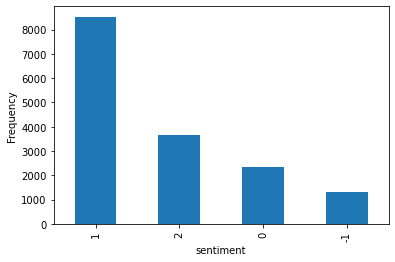

In [6]:
train_df.sentiment.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('sentiment');

In [7]:
# Class count
pro_Climate, news_Fact, neutral, anti_Climate = train_df.sentiment.value_counts()

In [8]:
# Divide by class
neutral_df = train_df[train_df['sentiment']==0]
anti_Climate_df = train_df[train_df['sentiment']==-1]
pro_Climate_df = train_df[train_df['sentiment']==1]
news_Fact_df = train_df[train_df['sentiment']==2]

In [9]:
# As usual, we start by importing our modules
from sklearn.utils import resample

Random under-sampling:
 0    8530
-1    8530
 2    8530
 1    8530
Name: sentiment, dtype: int64


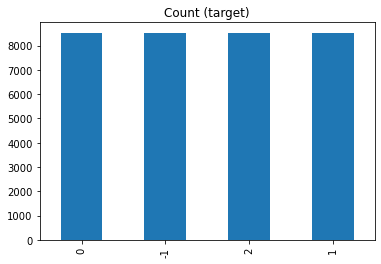

In [10]:
neutral_df_over = resample(neutral_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=pro_Climate, # match number in minority class
                          random_state=27)

anti_Climate_df_over = resample(anti_Climate_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=pro_Climate, # match number in minority class
                          random_state=27)
news_Fact_df_over = resample(news_Fact_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=pro_Climate, # match number in minority class
                          random_state=27)

df_test_over = pd.concat([neutral_df_over, anti_Climate_df_over, news_Fact_df_over, pro_Climate_df], axis=0)

print('Random under-sampling:')
print(df_test_over.sentiment.value_counts())

df_test_over.sentiment.value_counts().plot(kind='bar', title='Count (target)');

In [11]:
# neutral_df_over = neutral_df.sample(news_Fact, replace=True)
# anti_Climate_df_over = anti_Climate_df.sample(news_Fact, replace=True)
# pro_Climate_df_over = pro_Climate_df.sample(news_Fact)
# df_test_over = pd.concat([neutral_df_over, anti_Climate_df_over, pro_Climate_df_over, news_Fact_df], axis=0)

# print('Random under-sampling:')
# print(df_test_over.sentiment.value_counts())

# df_test_over.sentiment.value_counts().plot(kind='bar', title='Count (target)');

Most tweets support the man-made climate change which is represented by `1` while we have a fewer anti-climate change tweets

# Data Cleaning and Wrangling 

### Creating a function to clean the `message`

In [12]:
# sentiment_list
sentiment_list = ['Neutral', 'Anti-Climate', 'Pro-Climate','News-Fact']

In [13]:
# # creating a function to stem each words
stemmer = SnowballStemmer('english')
# creating a function to lemmatize each words
lemmatizer = WordNetLemmatizer()

In [14]:
# creating a function
def cleaning(tweet):
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    rem_link = re.sub(pattern, '', tweet)
    rem_punct = re.sub(r'[^a-zA-Z ]', '', rem_link)
    rem_punct = re.sub(r'RT', '', rem_punct)
    word_split = rem_punct.lower().split()
    stops = set(stopwords.words("english"))
    without_stop_sent = ' '.join([t for t in word_split if t not in stops])
    return without_stop_sent

df_test_over['cleaned_tweet'] = df_test_over.message.apply(cleaning)

In [15]:
def stemmer_fn(words, stemmer):
    word_split = set(words.split())
    return ' '.join([stemmer.stem(word) for word in word_split])

df_test_over['stem_tweet'] = df_test_over.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [16]:
def lemmatizer_fn(words, lemmatizer):
    word_split = set(words.split())
    return ' '.join([lemmatizer.lemmatize(word) for word in word_split])

df_test_over['lemma_tweet'] = df_test_over['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))

In [17]:
df_test_over.head()

,sentiment,message,tweetid,cleaned_tweet,stem_tweet,lemma_tweet
6841,0,"RT @kady: Don't worry, people can now start co...",937757,kady dont worry people start complaining took ...,took two year ambassador complain peopl kadi n...,took two year ambassador complaining people ka...
4894,0,"Gold's gone, many other minerals almost gone, ...",364120,golds gone many minerals almost gone weve rest...,sought gold almost china import weve climat pl...,sought gold almost china import weve climate p...
8696,0,@GlblCtzn dont fight climate change everyone u...,201783,glblctzn dont fight climate change everyone un...,glblctzn fight caus everyon climat understand ...,glblctzn fight cause everyone climate understa...
906,0,What do you guys think of Trump's stance on cl...,558046,guys think trumps stance climate change global...,think global stanc climat trump warm chang guy,think global stance climate trump warming chan...
6741,0,An upside to climate change is that I'm wearin...,816243,upside climate change im wearing shorts tshirt...,short wear tshirt novemb climat im upsid chang,short wearing tshirt november climate im upsid...


In [18]:
# vectorize
vectorizer = CountVectorizer(analyzer = "word",
                             min_df=2,
#                              max_df = 0.5,
#                              ngram_range=(1, 5),
                             max_features = None) 

In [19]:
reviews_vect = vectorizer.fit_transform(df_test_over['lemma_tweet'])

In [20]:
train_data_features = reviews_vect.toarray() # for fast fitting of our dataset
train_data_features.shape

(34120, 13795)

In [21]:
y = np.array(df_test_over['sentiment'])
X = train_data_features

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [46]:
def modelling(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, coln_index=None):
    model.fit(X_train, y_train)
    pred_lm = model.predict(X_test)
    # Plotting confusion matrix
    cm = confusion_matrix(y_test, pred_lm)
    cm_df = pd.DataFrame(cm, index = sentiment_list, columns = sentiment_list)
    cr_df = pd.DataFrame(classification_report(y_test, pred_lm, target_names=sentiment_list, output_dict=True))
    
    #Plotting the confusion matrix
    plt.figure(figsize=(10,5))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print('Confusion Matrix')
    display(cm_df)
    print('Classification Report')
    display(cr_df)
    
    return cm_df, cr_df, cm

[LibLinear]

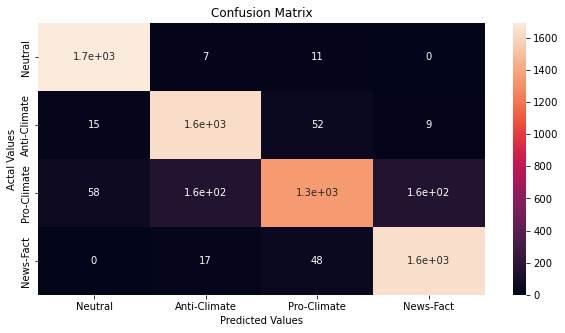

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,1691,7,11,0
Anti-Climate,15,1627,52,9
Pro-Climate,58,156,1342,155
News-Fact,0,17,48,1636


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.958617,0.900387,0.923606,0.908889,0.922626,0.922875,0.922911
recall,0.989468,0.955373,0.784337,0.961787,0.922626,0.922741,0.922626
f1-score,0.973798,0.927066,0.848293,0.934590,0.922626,0.920937,0.920894
support,1709.000000,1703.000000,1711.000000,1701.000000,0.922626,6824.000000,6824.000000


In [47]:
# create logistic regression model instance
lm = LogisticRegression(C=2, penalty='l2', solver='liblinear', verbose=1)
cm_df_logit, cr_df_logit, cm_logit = modelling(lm,  coln_index=sentiment_list)

In [49]:
cm_logit

array([[1691,    7,   11,    0],
       [  15, 1627,   52,    9],
       [  58,  156, 1342,  155],
       [   0,   17,   48, 1636]], dtype=int64)

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

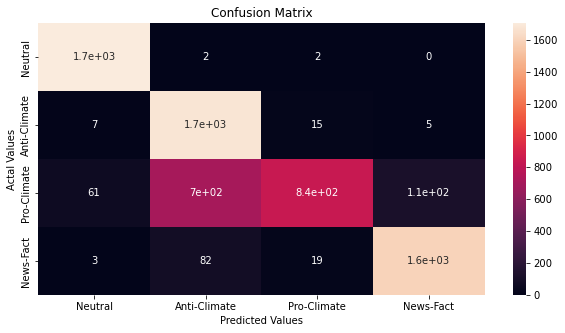

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,1705,2,2,0
Anti-Climate,7,1676,15,5
Pro-Climate,61,701,835,114
News-Fact,3,82,19,1597


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.960023,0.681024,0.958668,0.930653,0.851846,0.882592,0.882735
recall,0.997659,0.984146,0.488019,0.938859,0.851846,0.852171,0.851846
f1-score,0.978479,0.804995,0.646785,0.934738,0.851846,0.841249,0.841115
support,1709.000000,1703.000000,1711.000000,1701.000000,0.851846,6824.000000,6824.000000


In [50]:
n_neighbors = 1 # <--- change this number to play around with how many nearest neighbours to look for.

knn = KNeighborsClassifier(n_neighbors)
cm_df_knn, cr_df_knn, cm_knn = modelling(knn,  coln_index=sentiment_list)

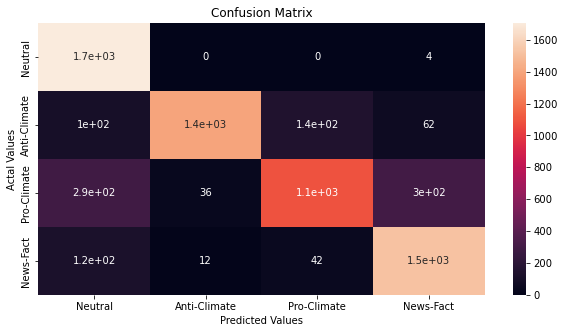

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,1705,0,0,4
Anti-Climate,102,1395,144,62
Pro-Climate,288,36,1088,299
News-Fact,124,12,42,1523


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.768364,0.966736,0.854003,0.806674,0.836899,0.848944,0.848892
recall,0.997659,0.819143,0.635885,0.895356,0.836899,0.837011,0.836899
f1-score,0.868126,0.886840,0.728978,0.848704,0.836899,0.833162,0.833066
support,1709.000000,1703.000000,1711.000000,1701.000000,0.836899,6824.000000,6824.000000


In [51]:
naive_bayes = GaussianNB()
cm_df_naive, cr_df_naive, cm_naive = modelling(naive_bayes,  coln_index=sentiment_list)

#### Cleaning the test dataset

In [27]:
test_df['cleaned_tweet'] = test_df.message.apply(cleaning)
test_df['lemma_tweet'] = test_df['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))
test_df['stem_tweet'] = test_df.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [28]:
test_df

,message,tweetid,cleaned_tweet,lemma_tweet,stem_tweet
0,Europe will now be looking to China to make su...,169760,europe looking china make sure alone fighting ...,sure china looking alone climate make europe c...,sure china look alon climat make europ chang f...
1,Combine this with the polling of staffers re c...,35326,combine polling staffers climate change womens...,woman combine state climate right staffer poll...,women combin state climat right staffer poll f...
2,"The scary, unimpeachable evidence that climate...",224985,scary unimpeachable evidence climate change al...,unimpeachable evidence climatechange climate s...,unimpeach evid climatechang climat scari itsti...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin got ...,doesnt got change morgfair jill trump putin ho...,doesnt got chang morgfair jill trump putin hoa...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,fakewillmoore female orgasms cause global warm...,republican global female warmingsarcastic fake...,republican global femal warmingsarcast fakewil...
...,...,...,...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about ...",895714,brittanybohrer brb writing poem climate change...,brb poem brittanybohrer alternativefacts clima...,brb poem brittanybohr alternativefact climatec...
10542,2016: the year climate change came home: Durin...,875167,year climate change came home hottest year rec...,mathiesen came home record hottest climate tra...,mathiesen came home record hottest climat trav...
10543,RT @loop_vanuatu: Pacific countries positive a...,78329,loopvanuatu pacific countries positive fiji le...,positive global november country conference cl...,posit global novemb countri confer climat fiji...
10544,"RT @xanria_00018: You’re so hot, you must be t...",867455,xanria youre hot must cause global warming ald...,aldublaboroflove global xanria jophie hot warm...,aldublaboroflov global xanria jophi hot warm a...


In [29]:
reviews_vect_test = vectorizer.transform(test_df['lemma_tweet'])

In [30]:
test_data_features = reviews_vect_test.toarray() # for fast fitting of our dataset
test_data_features.shape

(10546, 13795)

In [31]:
lm = LogisticRegression(C=2, penalty='l2', solver='liblinear', verbose=1)
lm.fit(X_train, y_train)
pred_lm = lm.predict(test_data_features)

[LibLinear]

In [32]:
# Saving test predictions to file
output = pd.DataFrame({'tweetid': test_df.tweetid,
                       'sentiment': pred_lm})
output.to_csv('submission.csv', index=False)

# Tracking with comet

In [33]:
params_knn = {"random_state": 10,
          "model_type": "knn"
          }

metrics_knn = {"f1": cr_df_knn.loc['f1-score', 'weighted avg'],
               "precision": cr_df_knn.loc['precision', 'weighted avg'],
               "recall": cr_df_knn.loc['recall', 'weighted avg']
           }

In [34]:
params_lm = {"random_state": 10,
          "model_type": "lm"
          }
metrics_lm = {"f1": cr_df_logit.loc['f1-score', 'weighted avg'],
           "precision": cr_df_logit.loc['precision', 'weighted avg'],
           "recall": cr_df_logit.loc['recall', 'weighted avg']
           }

In [35]:
params_naive = {"random_state": 10,
          "model_type": "naive"
          }
metrics_naive = {"f1": cr_df_naive.loc['f1-score', 'weighted avg'],
           "precision": cr_df_naive.loc['precision', 'weighted avg'],
           "recall": cr_df_naive.loc['recall', 'weighted avg']
           }

In [63]:
experiment.log_parameters(params_naive)
experiment.log_metrics(metrics_naive)
experiment.log_confusion_matrix(y_test, naive_bayes.predict(X_test))

{'web': 'https://www.comet.ml/api/asset/download?assetId=52332f34a77d40168fe9584e315759ed&experimentKey=ab2b648a6d624aeca334313cef02c14e',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=52332f34a77d40168fe9584e315759ed&experimentKey=ab2b648a6d624aeca334313cef02c14e',
 'assetId': '52332f34a77d40168fe9584e315759ed'}

In [68]:
experiment.log_parameters(params_lm)
experiment.log_metrics(metrics_lm)
experiment.log_confusion_matrix(y_test, lm.predict(X_test))

{'web': 'https://www.comet.ml/api/asset/download?assetId=ffd75cd2ef2147c59564282381d43eea&experimentKey=60e961847548481aa632d84611963ecd',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=ffd75cd2ef2147c59564282381d43eea&experimentKey=60e961847548481aa632d84611963ecd',
 'assetId': 'ffd75cd2ef2147c59564282381d43eea'}

In [71]:
experiment.log_parameters(params_knn)
experiment.log_metrics(metrics_knn)
experiment.log_confusion_matrix(y_test, knn.predict(X_test))

{'web': 'https://www.comet.ml/api/asset/download?assetId=4dc41bd349be4814a8e2c742e2dbc977&experimentKey=a4d3badda284475c8b45a1fe99acba4b',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=4dc41bd349be4814a8e2c742e2dbc977&experimentKey=a4d3badda284475c8b45a1fe99acba4b',
 'assetId': '4dc41bd349be4814a8e2c742e2dbc977'}

In [72]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/roceey/edsa-climate-change-belief-analysis/a4d3badda284475c8b45a1fe99acba4b
COMET INFO:   Metrics:
COMET INFO:     f1        : 0.841114759017274
COMET INFO:     precision : 0.8827350255527276
COMET INFO:     recall    : 0.8518464243845252
COMET INFO:   Parameters:
COMET INFO:     model_type   : knn
COMET INFO:     random_state : 10
COMET INFO:   Uploads:
COMET INFO:     conda-info               : 1
COMET INFO:     conda-specification      : 1
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (8.54 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook      